# CUNEF MUCD 2022/2023

# Machine Learning
# Análisis de Fraude¶

### Autores:
- Gozde Yazganoglu
- Irma Sanchez

In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve

from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix


from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import Pipeline

import pickle
import warnings
warnings.filterwarnings('ignore')


from aux_func import evaluate_model, cargar_modelo

In [6]:
xtrain = pd.read_parquet("../data/processed/xtrain.parquet")
ytrain = pd.read_parquet("../data/processed/ytrain.parquet")
xtest = pd.read_parquet("../data/processed/xtest.parquet")
ytest = pd.read_parquet("../data/processed/ytest.parquet")

In [7]:
#Cargamos pipeline preprocesado
preprocessor = cargar_modelo('../models/preprocessor.pickle')

# ADA BOOST MODEL

El nombre Adaboost viene de la mezcla entre Adaptive y Boosting, que son las dos características principales
que ocupa el algoritmo.

Los modelos boosting buscan encontrar un clasificador general o “fuerte”, en base a la combinación de una serie de clasificadores específicos o débiles, además a diferencia de las técnicas bagging, que hace un remuestreo aleatorio de los datos de entrenamiento, boosting pondera las muestras para concentrar el aprendizaje en los casos más difíciles.
Intuitivamente, se sabe que los casos más cercanos a la frontera de decisión son más difíciles de clasificar, por lo que recibirán pesos más altos. 

Se dice Adaptive, porque el clasificador “fuerte” se va adaptando y seleccionando los clasificadores débiles en función de los resultados que va obteniendo durante el entrenamiento. Este es un clasificador de tipo estadístico ya que usa características que se basan en la información cuantitativa de uno o varios elementos a estudiar. 

In [8]:
clf_ada = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', AdaBoostClassifier(n_estimators=100, random_state=0))])

In [9]:
clf_ada.fit(xtrain, ytrain)

Pipeline(steps=[('preprocesador',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['step', 'amount',
                                                   'connection_time',
                                                   'oldbalanceOrg', 'age',
                                                   'newbalanceOrig',
                                                   'user_number',
                                                   'user_connections',
                                                   'security_alert',
                                                   'oldbalanceDest',
      

In [10]:
with open('../models/model_Ada.pickle', 'wb') as f:
    pickle.dump(clf_ada, f)

In [10]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/model_Ada.pickle', 'rb') as f:
    clf_ada = pickle.load(f)

Generamos las predicciones sobre los datos de validación y evaluamos el modelo.

In [11]:
ypred = clf_ada.predict(xtest)
ypred_proba = clf_ada.predict_proba(xtest)
evaluate_model(ytest,ypred,ypred_proba)

ROC-AUC score of the model: 0.9946321356121499
Accuracy of the model: 0.9995613093960851

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.97      0.62      0.75       228

    accuracy                           1.00    209715
   macro avg       0.98      0.81      0.88    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209482      5]
 [    87    141]]



## Ajuste del umbral de predicción

Ajustamos el umbral de la predicción

In [18]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.482567, G-Mean=0.971
ROC-AUC score of the model: 0.9946321356121499
Accuracy of the model: 0.9689340295162483

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    209487
           1       0.03      0.97      0.06       228

    accuracy                           0.97    209715
   macro avg       0.52      0.97      0.52    209715
weighted avg       1.00      0.97      0.98    209715


Confusion matrix: 
[[202979   6508]
 [     7    221]]



El efecto del ajuste del threshold sobre el modelo ha sido parecido al observado previamente en el resto de modelos. Los resultados obtenidos son ligeramente inferiores.

El modelo ADA Boost ha obtenido un recall del 97% para las dos clases.

In [ ]:
ROC CURVE

In [13]:
# Adjusting threshold
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(ytest, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(ytest,ypred_new_threshold,ypred_proba)

Best Threshold=0.482567, G-Mean=0.971
ROC-AUC score of the model: 0.9946321356121499
Accuracy of the model: 0.9689340295162483

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    209487
           1       0.03      0.97      0.06       228

    accuracy                           0.97    209715
   macro avg       0.52      0.97      0.52    209715
weighted avg       1.00      0.97      0.98    209715


Confusion matrix: 
[[202979   6508]
 [     7    221]]



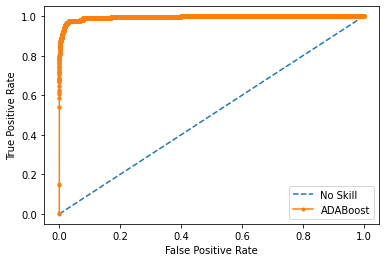

In [21]:
import matplotlib.pyplot as plt
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='ADABoost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [15]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.482567, G-Mean=0.971


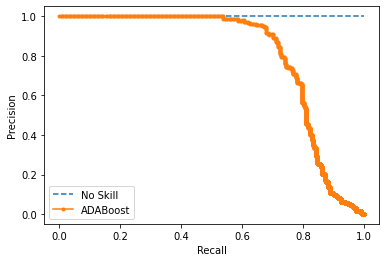

In [22]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(ytest, yhat)
# plot the roc curve for the model
no_skill = len(ytest[ytest==1]) / len(ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='ADABoost')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

Best Threshold=0.497282, F-Score=0.792


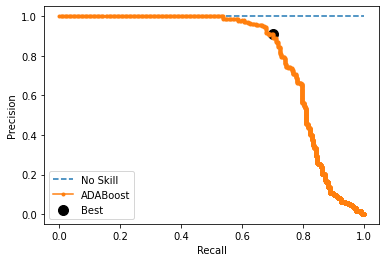

In [23]:
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(ytest[ytest==1]) / len(ytest)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='ADABoost')
plt.scatter(recall[ix], precision[ix], s=100, marker='o', color='black', label='Best')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
# show the plot
plt.show()

In [18]:
# evaluate the model
score = f1_score(ytest, ypred)
print('F-Score: %.5f' % score)

F-Score: 0.75401


In [ ]:
COMULATIVE GAIN CURVE

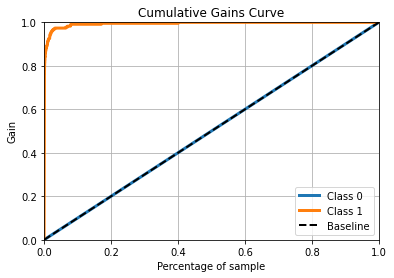

In [19]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_cumulative_gain(ytest, ypred_proba)
plt.show()

In [ ]:
LIFT CURVE

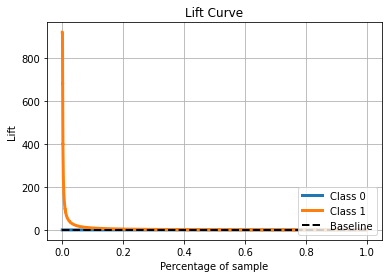

In [20]:
skplt.metrics.plot_lift_curve(ytest, ypred_proba)
plt.show()